In [156]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from skimage.color import rgb2gray
from skimage import data
from skimage.feature import match_template

In [157]:
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/Colab Notebooks/'
video = os.path.join(base_dir, 'lightfields2.MOV')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**(a) [10 points] Set up a static test scene using common household objects on a table top. You can use Fig. 1 above as inspiration. Try to have objects at different depths. Now capture a video of this scene by moving your cellphone camera in a zig-zag motion as shown below in Fig. 2. The more you cover the plane the better. Ensure that all objects are in focus in your video. Avoid tilting or rotating the camera as it will cause trouble in the algorithm we'll implement in the next part of the problem. The number of frames in this video will determine the time required to compute the output. So, make sure the video is not too long! Also make sure to capture this video in a well lit room with no lighting changes or scene motion.**

**(b) [10 points] Write a script to extract individual frames from this video. Since this video was captured from a cell phone, each frame image is in RGB color. Write a script to convert each frame to gray-scale and save them as a sequence of PNG or JPG files to disk. (There are several ways to do this in Python. For example, here's one possible way to use the imageio libraryLinks to an external site..) Display a subset of these images in, say, a grid of rows and columns that follows the camera motion path in Fig. 2. For example, you can choose to show a subset of 9 images in a 3x3 grid that approximately lines up with the motion in the video.**

In [158]:
vid_capture = cv2.VideoCapture(video)

flag, next_frame = vid_capture.read()

frame_counter = 0
while flag:
  gray_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
  cv2.imwrite('frame_'+str(frame_counter)+'.png', gray_frame)

  flag, next_frame = vid_capture.read()
  frame_counter += 1
  # print(frame_counter)

print('Total frames: '+str(frame_counter))

Total frames: 267


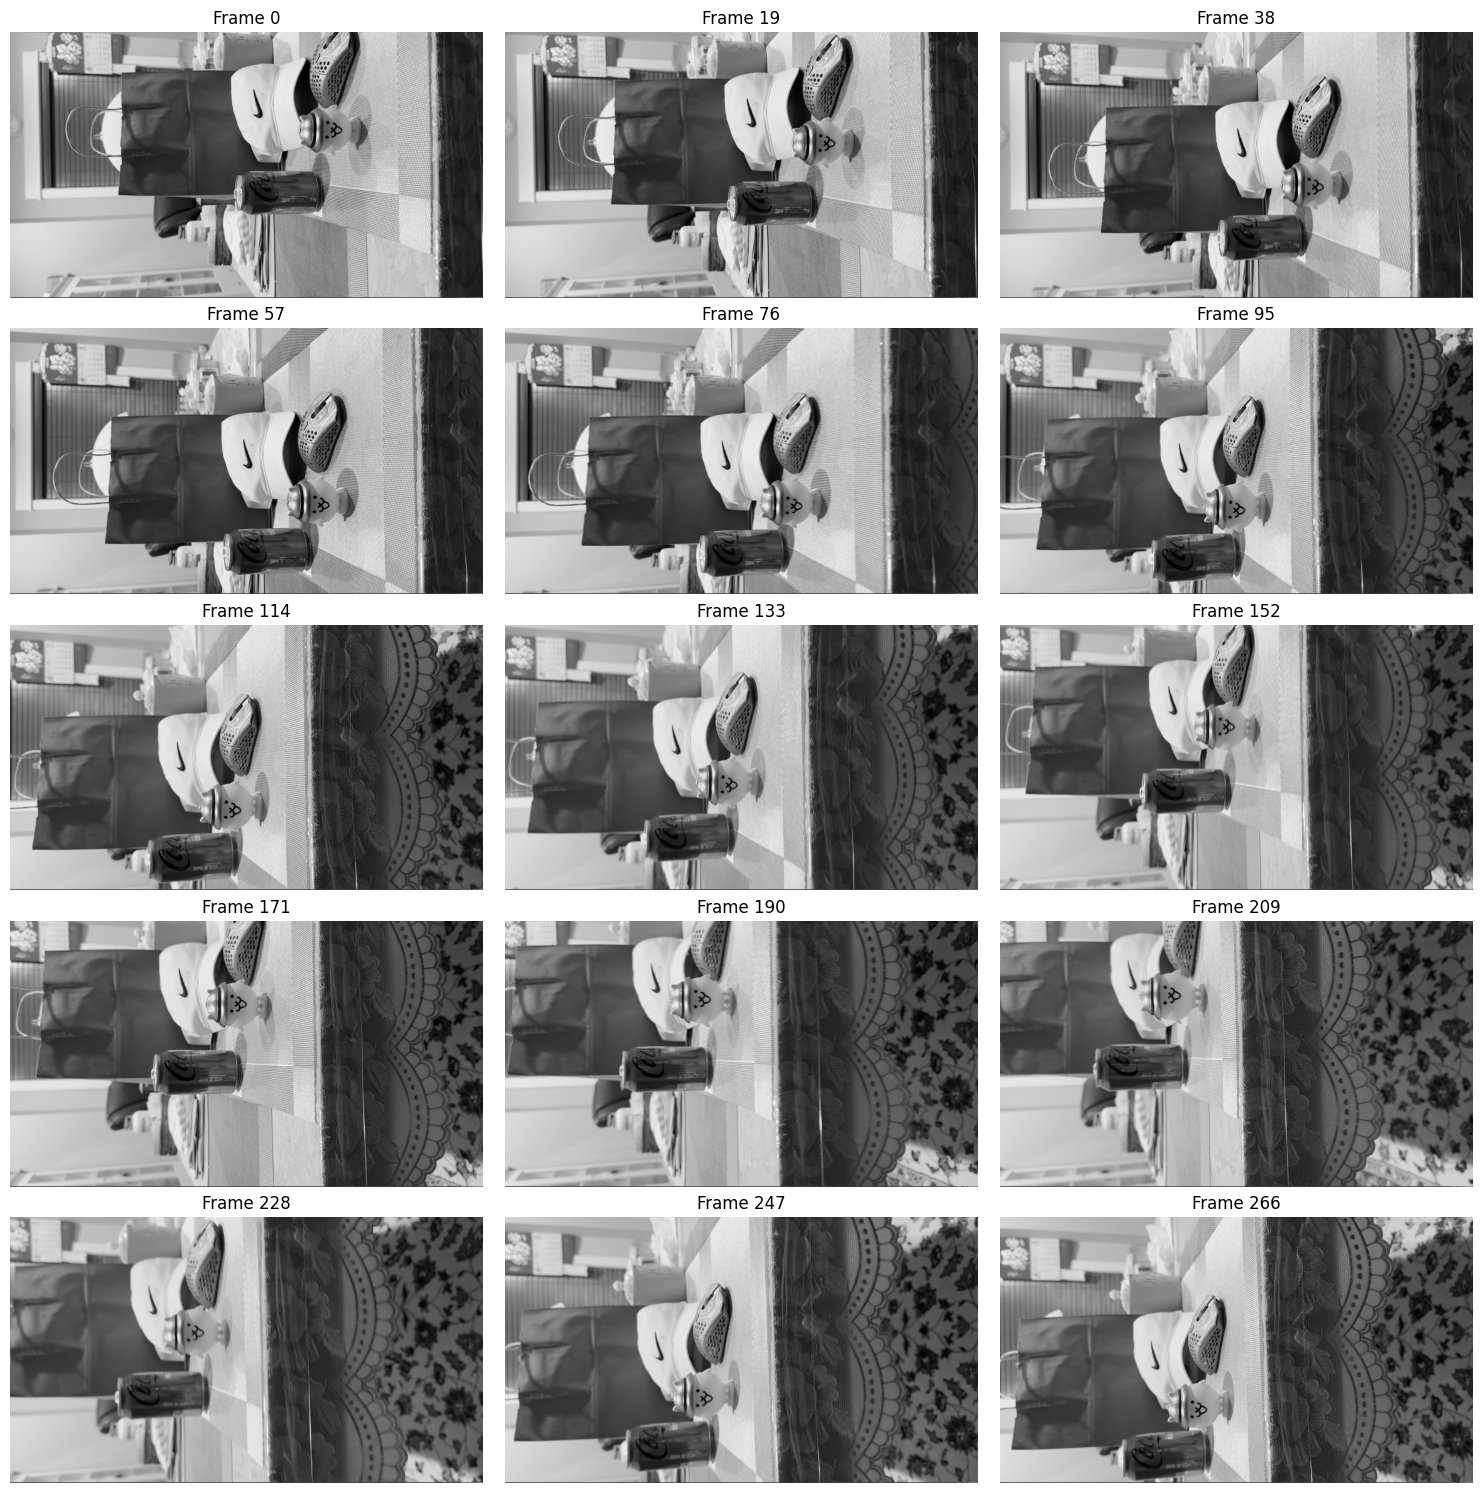

In [159]:
frame_indices = np.linspace(0, frame_counter - 1, 15, dtype=int)
image_files = [f'frame_{i}.png' for i in frame_indices]

fig, axes = plt.subplots(5, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)

    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {frame_indices[i]}')

plt.tight_layout()
plt.show()


**(c) [5 points] In the first video frame, select an object that you want to bring into focus. (For example, in Fig. 1, this was the bike helmet.) Crop it out. We will use this as a template that will be searched over all the remaining frames of the video. Display this cropped template in a new figure.**

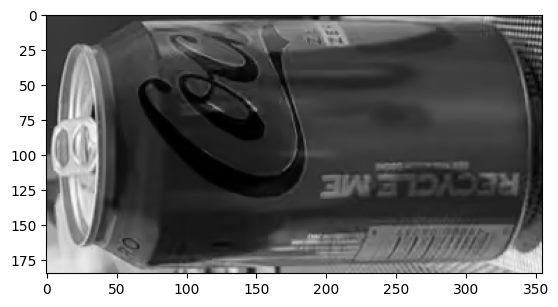

In [160]:
# I really like coco cola...
img1 = cv2.imread('frame_0.png')
crop = img1[560:745, 905:1260, :]
# plt.imshow(img1)
plt.imshow(crop[:,:,::-1])

(1080, 1920, 3)


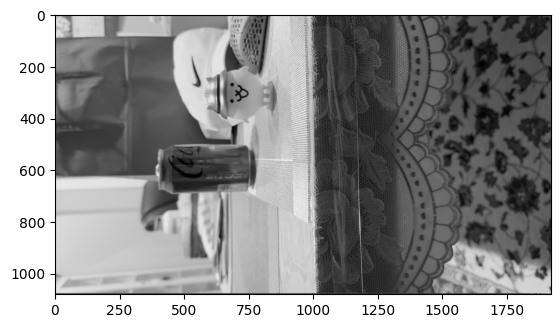

In [161]:
img213 = cv2.imread('frame_213.png')
print(img213.shape)
plt.imshow(img213[:,:,::-1])

Try and match template

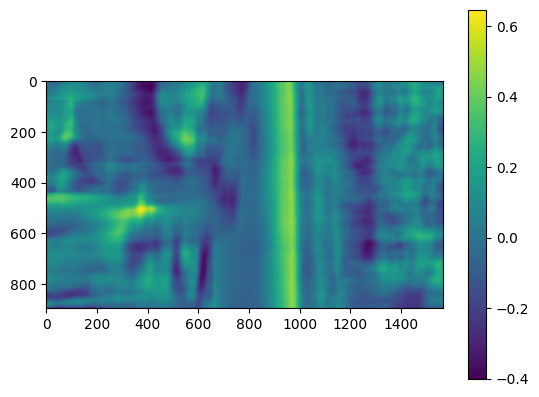

In [162]:
res = cv2.matchTemplate(img213, crop, cv2.TM_CCOEFF_NORMED)
best_location = cv2.minMaxLoc(res)
plt.imshow(res)
plt.colorbar()

**(d) [15 points] For each video frame from part (b), find the best matching pixel location for the template from part (c). You can use normalized cross-correlation template matching that we discussed in class. You can write this from scratch or use scikit-imageLinks to an external site. **

This method highlights them with a red rectangle

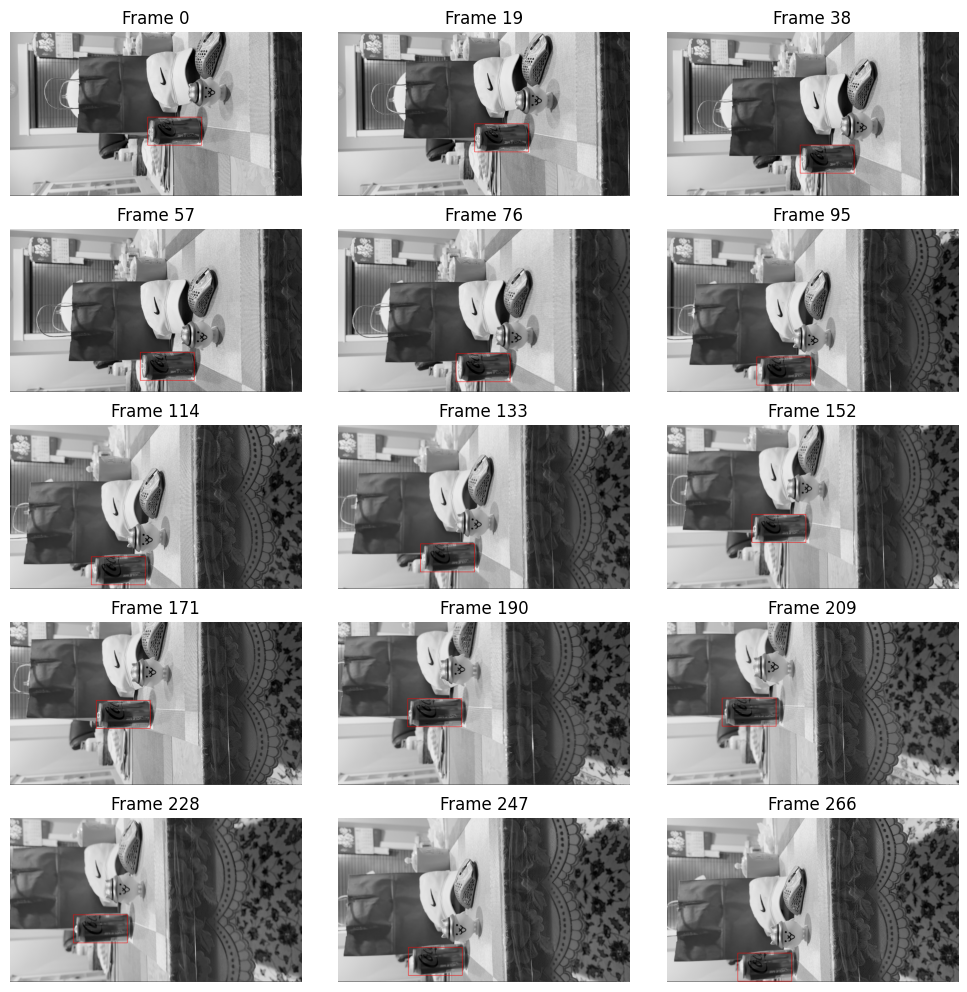

In [163]:
fig, axes = plt.subplots(5, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(image_files[i])
    res = cv2.matchTemplate(img, crop, cv2.TM_CCOEFF_NORMED)

    _, max_val, _, max_loc = cv2.minMaxLoc(res)
    x, y = max_loc

    img_with_rectangle = img.copy()
    height, width, _ = crop.shape
    cv2.rectangle(img_with_rectangle, (x, y), (x + width, y + height), (0, 0, 255), 2)
    # matched_region = img[y:y + height, x:x + width]

    ax.imshow(img_with_rectangle[:, :, ::-1])  # Convert BGR to RGB for matplotlib
    # ax.imshow(matched_region, cmap='gray')
    ax.set_title(f'Frame {frame_indices[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

This method zooms in/crops the image

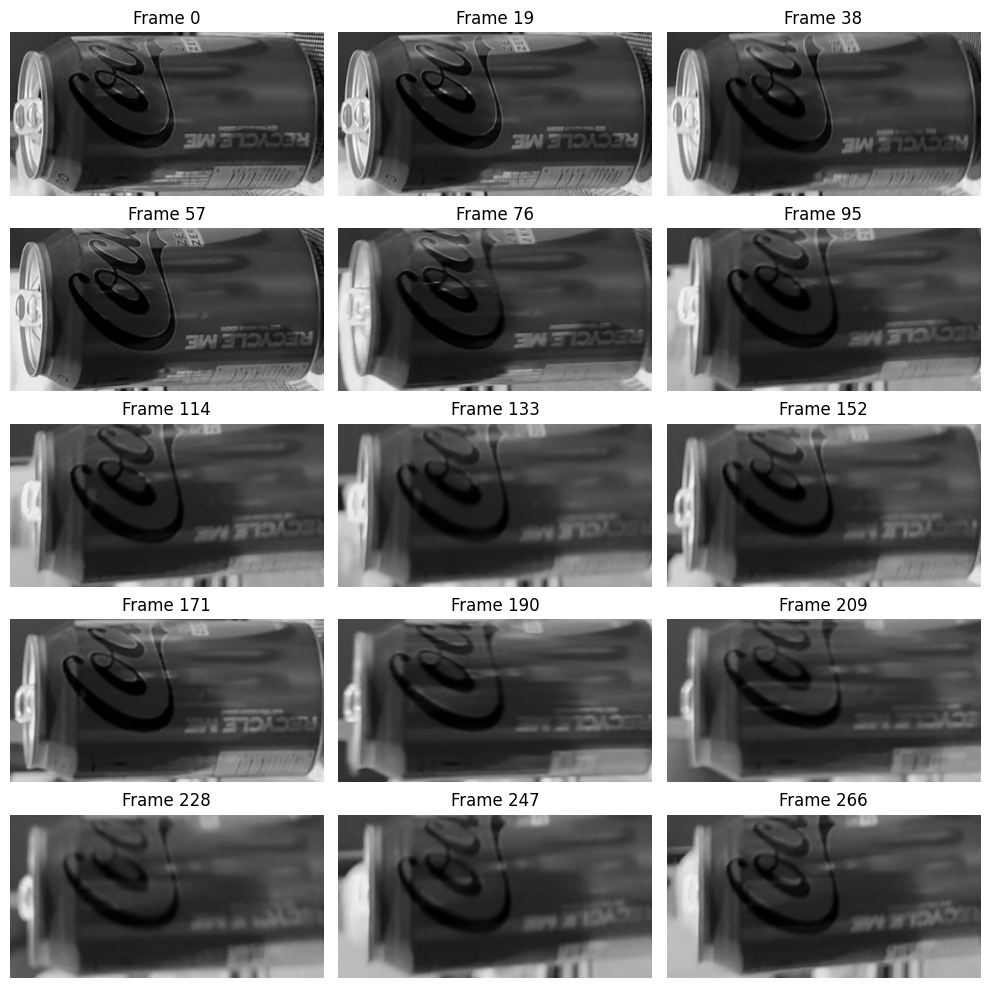

In [164]:
fig, axes = plt.subplots(5, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(image_files[i])
    res = cv2.matchTemplate(img, crop, cv2.TM_CCOEFF_NORMED)

    _, max_val, _, max_loc = cv2.minMaxLoc(res)
    x, y = max_loc

    img_with_rectangle = img.copy()
    height, width, _ = crop.shape
    # cv2.rectangle(img_with_rectangle, (x, y), (x + width, y + height), (0, 0, 255), 2)
    matched_region = img[y:y + height, x:x + width]

    # ax.imshow(img_with_rectangle[:, :, ::-1])  # Convert BGR to RGB for matplotlib
    ax.imshow(matched_region, cmap='gray')
    ax.set_title(f'Frame {frame_indices[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [165]:
nframes = 267
best_match_locations = np.zeros((2, nframes))
for frame_num in range(nframes):
  img = cv2.imread(f'frame_{frame_num}.png')
  res = cv2.matchTemplate(img, crop, cv2.TM_CCOEFF_NORMED)
  best_match_loc = cv2.minMaxLoc(res)[-1]
  best_match_locations[0, frame_num] = best_match_loc[0]
  best_match_locations[1, frame_num] = best_match_loc[1]

Text(0, 0.5, 'x-offset')

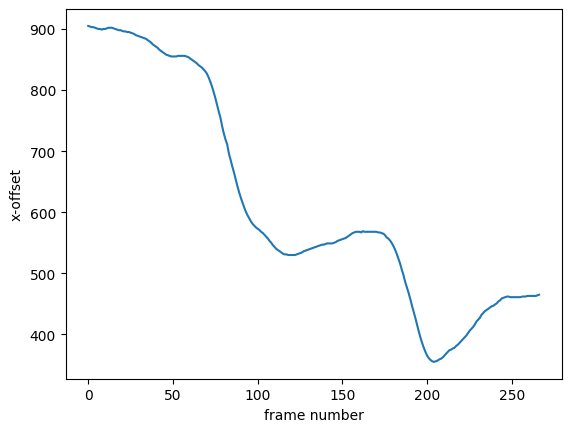

In [166]:
plt.plot(np.arange(nframes), best_match_locations[0,:])
plt.xlabel('frame number')
plt.ylabel('x-offset')

Text(0, 0.5, 'y-offset')

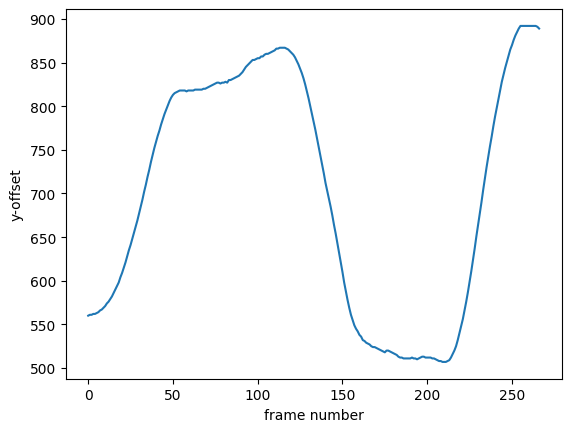

In [167]:
plt.plot(np.arange(nframes), best_match_locations[1,:])
plt.xlabel('frame number')
plt.ylabel('y-offset')

Text(0, 0.5, 'y-offset')

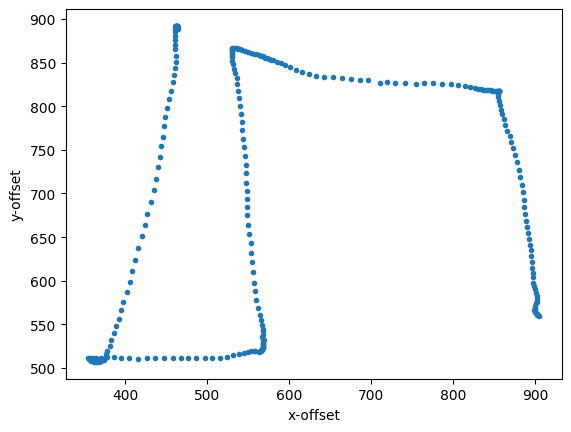

In [168]:
plt.plot(best_match_locations[0,:], best_match_locations[1,:], '.')
plt.xlabel('x-offset')
plt.ylabel('y-offset')

For the most part, my plots agree with the trajectory of the physical camera. In the final plot above, there seems to be a disconnect early on. This could be a few reasons but I believe this is because the code had trouble matching some frames betwen 75-100 which can be seen in the plots above.

**(e) [10 points] Once you have the pixel shifts for each frame, you can synthesize the refocused image by shifting each frame in the opposite direction and then summing up all the frames. Be careful of pixel indexes going out of bounds and pixel values over/underflowing. You may need to crop or extend the dimensions of each image frame. Display your final result image with the selected object in focus and background out of focus. If you see any artifacts comment on what may be causing them.**



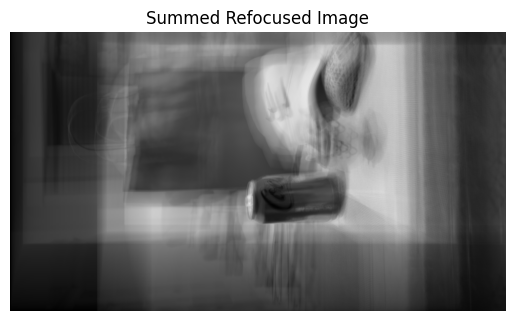

In [169]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume best_match_locations is already defined
translation = best_match_locations - best_match_locations[:, 0][:, np.newaxis]  # Calculate translations relative to the first frame

# Loop through all frames
nframes = 267  # Total number of frames
summed_frames = np.zeros((h, w, 3), dtype=np.float32)
for frame_num in range(nframes):
    # Load the current frame
    img = cv2.imread(f'frame_{frame_num}.png')  # Replace with the appropriate frame file paths
    if img is None:
        print(f"Error: Could not load frame {frame_num}. Skipping.")
        continue

    # Get frame dimensions
    h, w = img.shape[:2]

    # Extract dynamic translations for the current frame
    tx = abs(translation[0, frame_num])
    ty = translation[1, frame_num]

    # Create the affine transformation matrix using the current frame's translation
    T = np.float32([[1, 0, +tx], [0, 1, -ty]])

    # Apply the affine transformation
    img_shifted = cv2.warpAffine(img, T, (w, h))

    summed_frames += img_shifted.astype(np.float32)

    # # Display the shifted frame for verification
    # plt.imshow(img_shifted[:, :, ::-1])  # Convert BGR to RGB for Matplotlib
    # plt.title(f"Frame {frame_num} Shifted (tx={tx:.2f}, ty={ty:.2f})")
    # plt.axis('off')
    # plt.show()

summed_frames = np.clip(summed_frames / nframes, 0, 255).astype(np.uint8)

plt.imshow(summed_frames[:, :, ::-1])  # Convert BGR to RGB for Matplotlib
plt.title("Summed Refocused Image")
plt.axis('off')
plt.show()


Image we wanted to focus in below

[-440.  329.]
440.0 329
Hardcoded T:
[[   1.    0.  440.]
 [   0.    1. -329.]]
Dynamic T:
[[   1.    0.  440.]
 [   0.    1. -329.]]


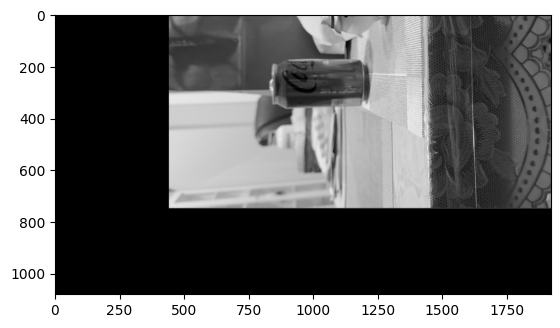

In [170]:
translation = best_match_locations - best_match_locations[:,0][:,np.newaxis]
print(translation[:,266])
tx = abs(translation[0, 266])
ty = round(translation[1, 266])
print(tx, ty)
print("Hardcoded T:")
print(np.float32([[1, 0, +440], [0, 1, -329]]))

print("Dynamic T:")
print(np.float32([[1, 0, +tx], [0, 1, -ty]]))


T = np.float32([[1,0, +440],[0,1,-329]])
h,w = img213.shape[:2]
img213_shifted = cv2.warpAffine(img213, T, (w,h))

plt.imshow(img213_shifted[:,:,::-1])

**(f) [CS410=10 points | CS510=5 points] What is the runtime complexity of the algorithm in part (d)? (Express it using big-Oh notation in terms of the pixel resolution of the image and the number of frames.)**

I believe there are 3 factors that come into play for the runtime complexity of the algorithm in part (d). The number of frames (nframes) and the resolution of each frame (h * w). So because of this, the runtime would be big O(nframes * (h * x)). This however, also doesn't account for the reading of the images from the disk (D).

**[CS510=5 points] Propose some modifications to the algorithm to speed it up. (No need to implement them; only mention some speculative ideas in your write-up).**

Many of the improvements I can think of that we can do is a lot of hardware side related. Things like GPU acceleration and parallel processing. If we include the time it takes to read and load images from the disk (D), a way we could improve that part is to pre-load the images/frames into memory.

A way online/chatGPT has provided I thought to be interesting is "precomputing or approximate translations" where if the translations are repetitive or follow a predictable pattern (like if we continued a longer video with the zig zag pattern), we could precomputer the transformations and reuse them.

I believe this would be a great approach for this project because of the predictable zig zag pattern we used.